# Museum Feedback Aggregator


## Imports

In [1]:
# installations
!pip install transformers sentencepiece

In [40]:
# imports
from itertools import groupby
import pandas as pd

# NN
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Plots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# data path and file name
DATA_PATH = './data/'
dataset_name = 'museum_feedback.xlsx'

## Model functions

In [26]:
# sentiment model
sentiment_tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
sentiment_model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment', return_dict=True)
sentiment_map = {
    0: 'neutral',
    1: 'positive',
    2: 'negative'
}

@torch.no_grad()
def predict_sentiment(text):
    inputs = sentiment_tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = sentiment_model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).numpy()
    predicted = sentiment_map[predicted[0]]
    return predicted



In [31]:
# keyphrases model
model_name = "0x7194633/keyt5-base" # or 0x7194633/keyt5-base
keyphrases_tokenizer = T5Tokenizer.from_pretrained(model_name)
keyphrases_model = T5ForConditionalGeneration.from_pretrained(model_name)

def generate_keyphrases(text, **kwargs):
    inputs = keyphrases_tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        hypotheses = keyphrases_model.generate(**inputs, num_beams=5, **kwargs)
    s = keyphrases_tokenizer.decode(hypotheses[0], skip_special_tokens=True)
    s = s.replace('; ', ';').replace(' ;', ';').lower().split(';')[:-1]
    s = [el for el, _ in groupby(s)]
    return s

## Interpritation function

In [ ]:
# museum interpritation function
def museum_review(museum_name):
  """Plot some charts about museum
  inout:
  - museum_name(str): name of museum, that you want to see"""
  # get set by museum_name
  museum_dataset = dataset[dataset['museum_name']==museum_name]

  # Feedback sentiment chart
  fig = px.pie(museum_dataset['sentiment'].value_counts().reset_index(), values="sentiment", names='index', title = 'Feedback sentiment')
  fig.show()

  # Feedback rating chart
  fig = px.pie(museum_dataset['visitor_mark'].value_counts().reset_index(), values="visitor_mark", names='index', title = 'Feedback rating')
  fig.show()

  # Word cloud
  keyphrases = museum_dataset['keyphrases'].apply(lambda x: [i.replace(' ', '_') for i in x]).sum()
  keyphrases = [keyphrase for keyphrase in keyphrases if keyphrase != 'музей']

  plt.subplots(figsize = (8,8))

  wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate(' '.join(keyphrases))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

## Data pipline

In [ ]:
# data reading
if dataset_name.split('.')[-1]=='xlsx':
  dataset = pd.read_excel(f'{DATA_PATH}{dataset_name}')
elif dataset_name.split('.')[-1]=='csv':
  dataset = pd.read_excel(f'{DATA_PATH}{dataset_name}')

In [33]:
%%time
# it works in about 12 sec with a single feedback text
dataset['sentiment'] = dataset['feedback_text'].apply(predict_sentiment)
dataset['keyphrases'] = dataset['feedback_text'].apply(lambda text: generate_keyphrases(text, top_p=1.0, max_length=64))

CPU times: user 6min, sys: 767 ms, total: 6min 1s
Wall time: 7min 8s


## Result interpritation

In [142]:
museum_dataset['sentiment'].value_counts().reset_index()

,index,sentiment
0,positive,8
1,neutral,2


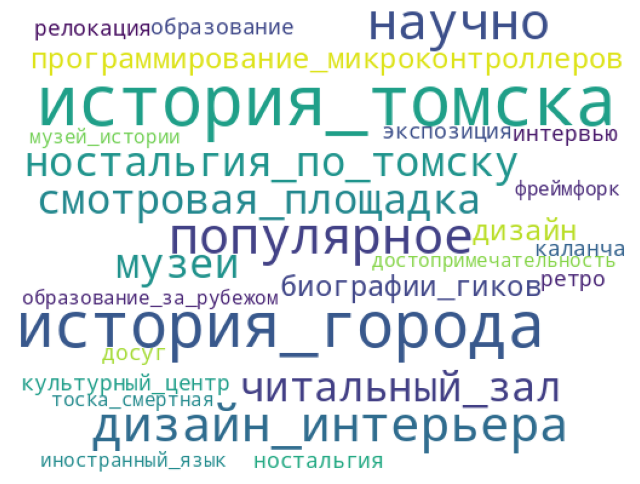

In [146]:
museum_name = 'Музей истории Томска'
museum_review(museum_name)

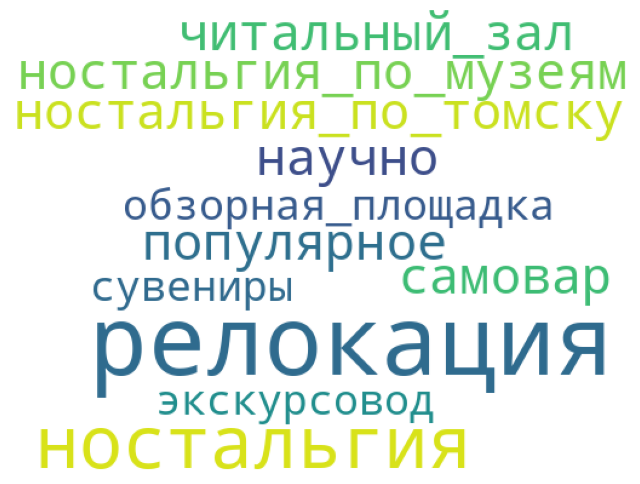

In [147]:
museum_name = 'Первый музей славянской мифологии'
museum_review(museum_name)

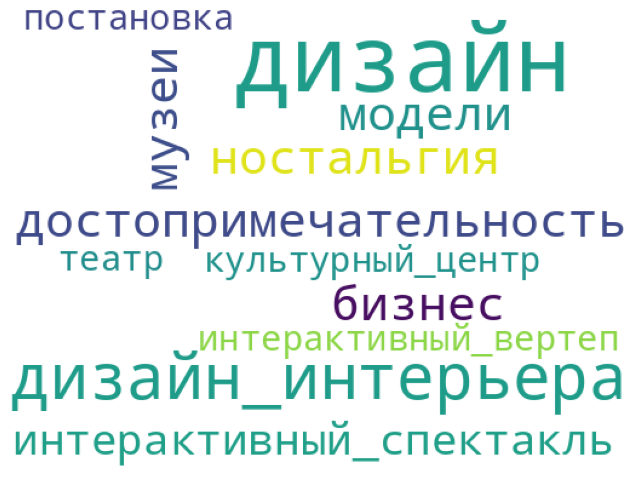

In [148]:
museum_name = 'Дом искусств'
museum_review(museum_name)